# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

### Install dependencies

In [43]:
!pip install torchio

### Mount data from GDrive

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Save transformed images from torchio to files

Unfortunately I could not get the direct loading of images via torchio to fastai2 to work - so this workaround seems simple enough.
Although it has some drawbacks (e.g. no on the fly calculations of different transforms every time) and advantages (e.g. fixed transform results for reproducibility, scaling can be moved to fastai so no need to scale the z direction).

In [45]:
import os
import torch
import torchio
from torchio.transforms import RescaleIntensity, RandomMotion, RandomGhosting, RandomSpike, RandomBiasField, RandomBlur, RandomNoise, RandomSwap, ZNormalization
from torchvision.transforms import Compose, ToPILImage
from torch.utils.data import DataLoader
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### CLAHE transformation for T2 and LGE

In [47]:
import nibabel as nib
import numpy as np
from skimage.exposure import equalize_adapthist as clahe
from skimage import img_as_int

In [48]:
t2_101 = nib.load('/content/drive/My Drive/miccai2020/myops/train25/myops_training_101_T2.nii.gz')
t2_101_data = np.asanyarray(t2_101.dataobj)

In [49]:
t2_101_data.shape

(478, 482, 5)

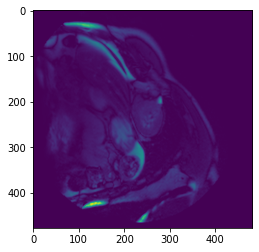

In [50]:
plt.imshow(t2_101_data[:,:,0])

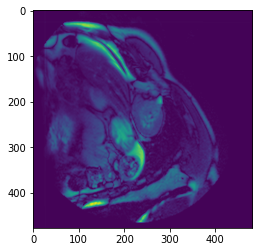

In [51]:
plt.imshow(clahe(t2_101_data[:,:,0]))

In [52]:
t2_101_data[:,:,0].max(), t2_101_data[:,:,0].dtype

(2041, dtype('<i2'))

In [53]:
cl = clahe(t2_101_data[:,:,0]).max()
cl.max(), cl.dtype

(1.0, dtype('float64'))

In [54]:
dim = t2_101_data.shape
cl = np.zeros(dim, dtype=np.int16)
for i in range(dim[2]):
  cl[:,:,i] = img_as_int(clahe(t2_101_data[:,:,i]))

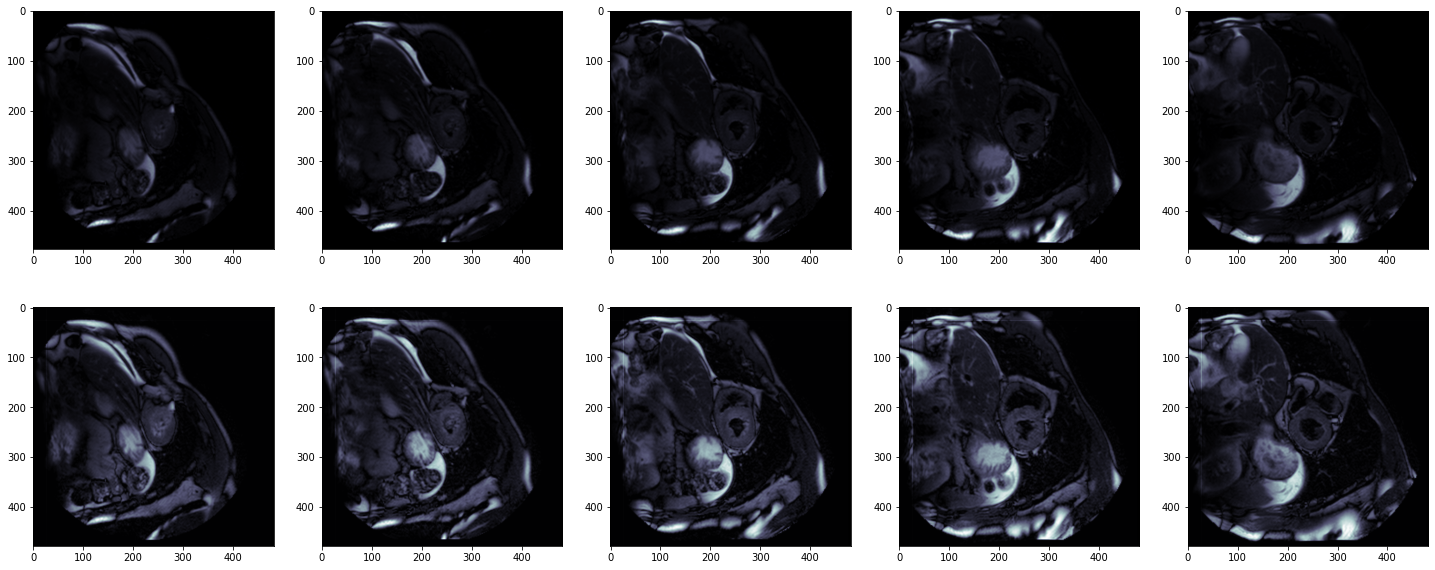

In [55]:
fig, axs = plt.subplots(2,5,figsize=(25,10))
for i in range(5):
  axs[0,i].imshow(t2_101_data[:,:,i], cmap="bone")
  axs[1,i].imshow(cl[:,:,i], cmap="bone")

In [56]:
t2_101_clahe = nib.Nifti1Image(cl, t2_101.affine, t2_101.header)
nib.save(t2_101_clahe, f'test.nii.gz')

In [58]:
files = glob('/content/drive/My Drive/miccai2020/myops/train25/myops_training_*_[DT][E2].nii.gz')
for f in tqdm(files):
  orig = nib.load(f)
  orig_data = np.asanyarray(orig.dataobj)
  dim = orig_data.shape
  cl = np.zeros(dim, dtype=np.int16)
  for i in range(dim[2]):
    cl[:,:,i] = img_as_int(clahe(orig_data[:,:,i]))
  cl_nii = nib.Nifti1Image(cl, orig.affine, orig.header)
  nib.save(cl_nii, f.replace('.nii.gz','_clahe.nii.gz'))

In [61]:
files = glob('/content/drive/My Drive/miccai2020/myops/train25/myops_training_*_C0.nii.gz')

In [62]:
subjects = [torchio.Subject(
    bssfp = torchio.Image(f, torchio.INTENSITY),
    LGE = torchio.Image(f.replace("C0","DE_clahe"), torchio.INTENSITY),
    T2 = torchio.Image(f.replace("C0","T2_clahe"), torchio.INTENSITY),
    label = torchio.Image(f.replace("train25","train25_myops_gd").replace("C0","gd"), torchio.LABEL),
    name = f.split("_")[2]
) for f in files]

In [63]:
transforms = [
    RescaleIntensity((0, 1)),  # applied only to torchio.INTENSITY images
    # CenterCropOrPad((256,256,5)),
    # RandomAffine(),  # applied to all images in the sample
    # RandomGhosting(),
]

# Transforms can be composed as in torchvision.transforms
transform = Compose(transforms)

# ImagesDataset is a subclass of torch.data.utils.Dataset
subjects_dataset = torchio.ImagesDataset(subjects, transform=transform)

In [64]:
plain_loader = DataLoader(subjects_dataset, batch_size=1, num_workers=1)

In [65]:
def get_x_y(element):
    x = torch.cat((element['bssfp']['data'][0],element['LGE']['data'][0],element['T2']['data'][0]),dim=0).permute(3,0,1,2)
    y = element['label']['data'][0,0,:,:,:]
    # The provided gold standard labels include: 
    # left ventricular (LV) blood pool (labelled 500),
    # right ventricular blood pool (600), 
    # LV normal myocardium (200),
    # LV myocardial edema (1220),
    # LV myocardial scars (2221), 
    # though the evaluation of the test data will be focused on the myocardial pathology segmentation, i.e., scars and edema. 
    y[y==500] = 1
    y[y==200] = 2
    y[y==600] = 3
    y[y==1220] = 4
    y[y==2221] = 5
    y=y.permute(2,0,1)
    return x,y

In [66]:
pil = ToPILImage()
path = "/content/drive/My Drive/miccai2020/myops/png_with_clahe"

In [67]:
for i in ['images','bssfp','LGE','T2','masks']:
  os.makedirs(f'{path}/{i}', exist_ok=True)

In [68]:
def generate_images_fromLoader(loader, name):
    for element in tqdm(loader):
        pid = element['bssfp']['stem'][0].split("_")[2]
        x,y = get_x_y(element)
        for i,(a,b) in enumerate(zip(x,y)):
            x_img = pil(a)
            x_img.save(f"{path}/images/{pid}-{name}-{i}.png")
            pil(a[0]).save(f"{path}/bssfp/{pid}-{name}-{i}.png")
            pil(a[1]).save(f"{path}/LGE/{pid}-{name}-{i}.png")
            pil(a[2]).save(f"{path}/T2/{pid}-{name}-{i}.png")
            y_img = Image.fromarray(b.int().numpy(), 'I')
            y_img.save(f"{path}/masks/{pid}-{name}-{i}.png")

### Convert original images

nifti to png, separate and composite

In [69]:
generate_images_fromLoader(plain_loader, "orig")

### Add images with artifacts

ghosting, motion, spike, B0 inhomogeneity, blurring, noise

In [70]:
iteration = 1
#dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomGhosting(),RescaleIntensity((0,1))])), batch_size=1)
#generate_images_fromLoader(dataset, f"ghost_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomMotion(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"motion_{iteration}")
#dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomSpike(),RescaleIntensity((0,1))])), batch_size=1)
#generate_images_fromLoader(dataset, f"spike_{iteration}")
#dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomBiasField(),RescaleIntensity((0,1))])), batch_size=1)
#generate_images_fromLoader(dataset, f"biasField_{iteration}")
#dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),RandomBlur(),RescaleIntensity((0,1))])), batch_size=1)
#generate_images_fromLoader(dataset, f"blur_{iteration}")
dataset = DataLoader(torchio.ImagesDataset(subjects, transform=Compose([RescaleIntensity((0,1)),ZNormalization(),RandomNoise(),RescaleIntensity((0,1))])), batch_size=1)
generate_images_fromLoader(dataset, f"noise_{iteration}")